In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd
import importlib

In [2]:
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [10]:
N = None

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_la_mass"]+["v0_la_massErr"]+ML1+ML2, entrystop = N)

mass_range = (1090,1145)

data = data.loc[(data.v0_la_mass > mass_range[0]) & (data.v0_la_mass < mass_range[1])]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

# path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
# file = uproot.open(path)
# mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

No background valid minimum found!
No valid minimum found!


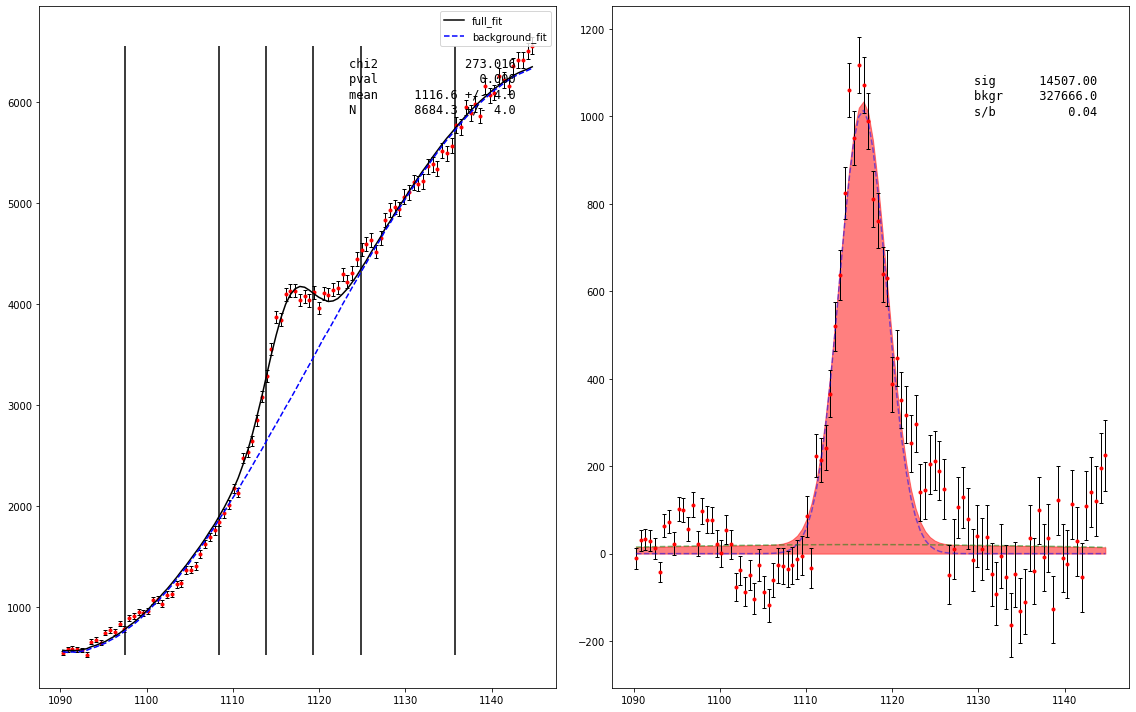

In [11]:
hm = importlib.reload(hm)

train_data = hm.assign_pseudolabels(train_data,type='la')

In [12]:
#Shuffle training data
train_data = train_data.sample(frac=1)

train_split = len(train_data)//2

print(train_data[:train_split].y.sum(),train_data[train_split:].y.sum())

12153.0 12250.0


In [13]:
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

cla1.fit(train_data[:train_split][ML1],y=train_data[:train_split].y)
cla2.fit(train_data[train_split:][ML2],y=train_data[train_split:].y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [14]:
p1 = cla1.predict_proba(test_data[ML1])[:,0]
p2 = cla2.predict_proba(test_data[ML2])[:,0]

No background valid minimum found!
No valid minimum found!



(1116.2205699636825,
 0.29236931270398575,
 {'chi2': 67.1348654366954, 'p': 0.0017626873263442177})

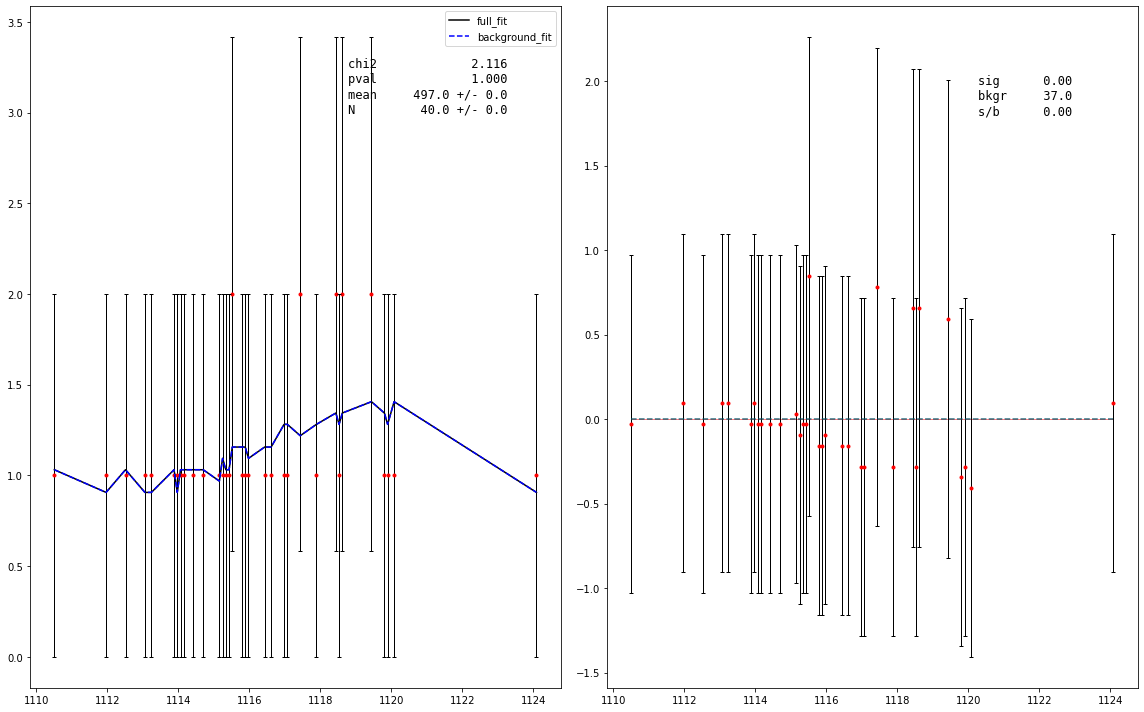

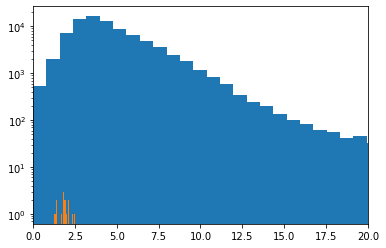

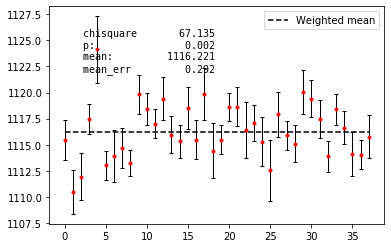

In [66]:
hm = importlib.reload(hm)
p_mask = (p1<=np.quantile(p1,0.006))&(p2<=np.quantile(p2,0.006))
mass_quantile = np.quantile(test_data.v0_la_mass[p_mask],(0,0.93))
# mass_quantile = np.quantile(test_data.v0_la_mass[p_mask],(0,1))
mask_mass = (p_mask)&(test_data.v0_la_mass>=mass_quantile[0])&(test_data.v0_la_mass<=mass_quantile[1])#&(test_data.v0_la_massErr <10)
vals, binc, binw = hm.hist(test_data.v0_la_mass[mask_mass],bins=150)

# fig, ax = plt.subplots()
# ax.hist(test_data.v0_ks_mass[p<=0.38],bins=100);
mask = vals >=1
D = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))
print()

plt.figure()
plt.hist(test_data.v0_la_massErr,bins=100);
plt.hist(test_data.v0_la_massErr[mask_mass],bins=100);
plt.yscale('log')
plt.xlim(0,20)

hm = importlib.reload(hm)
fig, ax = plt.subplots()
hm.weighted_mean(test_data.v0_la_mass[mask_mass],test_data.v0_la_massErr[mask_mass],ax=ax)
# ax.set_ylim(400,700)
# ax.set_ylim(475,550)

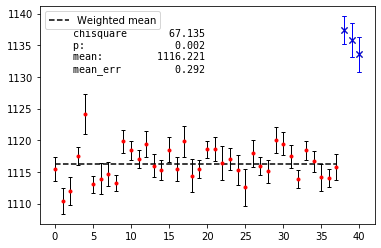

In [68]:
excluded = test_data[test_data.index.isin([5044625,5596485,5707856])]
ax.errorbar(range(sum(mask_mass),sum(mask_mass)+3), excluded.v0_la_mass, excluded.v0_la_massErr, c = 'b',marker='x', elinewidth = 1, capsize = 2, ls = 'none')
fig

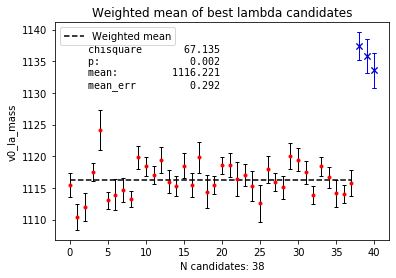

In [71]:
ax.set(title=('Weighted mean of best lambda candidates'),
      xlabel=f'N candidates: {sum(mask_mass)}',
      ylabel='v0_la_mass')
# fig.savefig('Lambda_mass_result.pdf')
fig

In [72]:
len(test_data)

85680

In [46]:
test_data[mask_mass].v0_la_mass>1130, [5044625,5596485,5707856]

entry
4724372    False
4728095    False
4769581    False
4781167    False
4802584    False
4802598    False
4812257    False
4814418    False
4816129    False
4967973    False
4968885    False
4996014    False
5010933    False
5024595    False
5044625     True
5048894    False
5053234    False
5072911    False
5129241    False
5212190    False
5212644    False
5226933    False
5228395    False
5281329    False
5284568    False
5318144    False
5333725    False
5387395    False
5491345    False
5519195    False
5521588    False
5596485     True
5682941    False
5706274    False
5707856     True
5738596    False
5764376    False
5822211    False
5834073    False
5860942    False
5868365    False
Name: v0_la_mass, dtype: bool

Draw ROC curves in data using fits:

In [30]:
p1 = cla1.predict_proba(test_data[ML1])[:,0]

Completed fit with Chi2: 98.9, p-val: 0.040 and the total amount of signal 3602 +/- 172, background: 82078
Completed fit with Chi2: 96.5, p-val: 0.056 and the total amount of signal 2670 +/- 154, background: 81298
No valid minimum found!
Completed fit with Chi2: 90.2, p-val: 0.127 and the total amount of signal 2019 +/- 2850, background: 80235
Completed fit with Chi2: 89.2, p-val: 0.143 and the total amount of signal 1471 +/- 144, background: 79070
Completed fit with Chi2: 84.1, p-val: 0.246 and the total amount of signal 999 +/- 3, background: 77827
Completed fit with Chi2: 80.5, p-val: 0.340 and the total amount of signal 648 +/- 1039, background: 76464
Completed fit with Chi2: 80.4, p-val: 0.344 and the total amount of signal 357 +/- 16, background: 75043
Completed fit with Chi2: 77.8, p-val: 0.420 and the total amount of signal 190 +/- 50, background: 73496
Completed fit with Chi2: 84.3, p-val: 0.240 and the total amount of signal 90 +/- 42, background: 71882
Completed fit with Chi

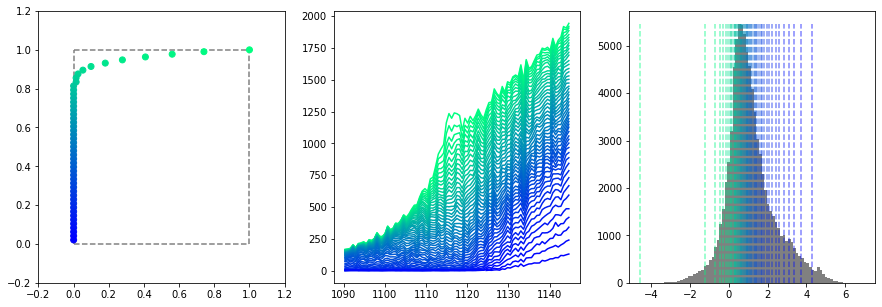

In [58]:
import importlib 
hm = importlib.reload(hm)

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_la_mass, p1,bins=85,Npoints=50,range=mass_range,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2],type='la')

In [61]:
ax1[0].set(title=f'Estimated ROC curve, AUC ~{1+AUC1:.4f}', xlabel='FPR', ylabel='TPR',ylim=(-0.05,1.05),xlim=(-0.05,1.05))
ax1[1].set(title='Distributions in mass',xlabel='k-short mass', ylabel='N')
ax1[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1.tight_layout()
fig1
# fig1.savefig('figures/ML1_roc_data_lambda.pdf')

In [34]:
p2 = cla2.predict_proba(test_data[ML2])[:,0]

Completed fit with Chi2: 98.9, p-val: 0.040 and the total amount of signal 3602 +/- 172, background: 82078
Completed fit with Chi2: 99.1, p-val: 0.039 and the total amount of signal 2407 +/- 327, background: 81560
Completed fit with Chi2: 95.1, p-val: 0.069 and the total amount of signal 1811 +/- 189, background: 80443
Completed fit with Chi2: 94.1, p-val: 0.078 and the total amount of signal 911 +/- 198, background: 79630
Completed fit with Chi2: 92.1, p-val: 0.101 and the total amount of signal 549 +/- 203, background: 78277
Completed fit with Chi2: 94.1, p-val: 0.078 and the total amount of signal 447 +/- 158, background: 76666
Completed fit with Chi2: 86.4, p-val: 0.195 and the total amount of signal 391 +/- 115, background: 75009
Completed fit with Chi2: 86.6, p-val: 0.190 and the total amount of signal 268 +/- 243, background: 73418
Completed fit with Chi2: 81.6, p-val: 0.310 and the total amount of signal 156 +/- 101, background: 71816
Completed fit with Chi2: 77.4, p-val: 0.433

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 79.3, p-val: 0.377 and the total amount of signal 111 +/- 100, background: 54726
Completed fit with Chi2: 82.0, p-val: 0.298 and the total amount of signal 98 +/- 12, background: 53024
Completed fit with Chi2: 77.0, p-val: 0.447 and the total amount of signal 147 +/- 4, background: 51261
Completed fit with Chi2: 80.6, p-val: 0.337 and the total amount of signal 47 +/- 134, background: 49648
Completed fit with Chi2: 79.2, p-val: 0.377 and the total amount of signal 69 +/- 41, background: 47913
Completed fit with Chi2: 81.2, p-val: 0.320 and the total amount of signal 103 +/- 89, background: 46165
Completed fit with Chi2: 75.9, p-val: 0.481 and the total amount of signal 68 +/- 10, background: 44486
Completed fit with Chi2: 82.0, p-val: 0.300 and the total amount of signal 102 +/- 98, background: 42738
Completed fit with Chi2: 84.4, p-val: 0.239 and the total amount of signal 153 +/- 152, background: 40974
Completed fit with Chi2: 76.6, p-val: 0.459 and the total

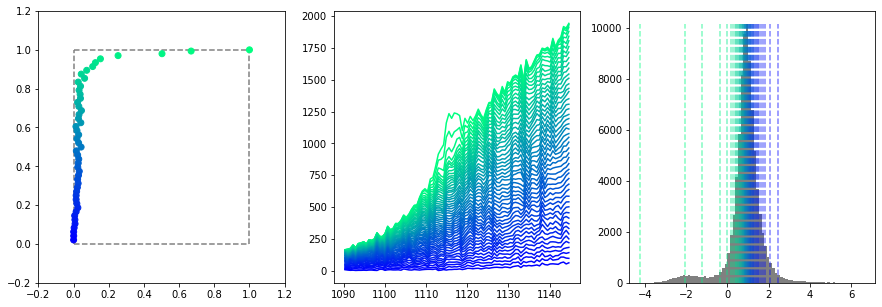

In [53]:
import importlib 
hm = importlib.reload(hm)

fig2, ax2 = plt.subplots(figsize = (15,5),ncols=3)

AUC2, cuts2 = hm.roc_curve_data(test_data.v0_la_mass, p2,bins=85,Npoints=50,range=mass_range,ax_roc=ax2[0],ax_fits=ax2[1],ax_hist=ax2[2],type='la')

In [55]:
ax2[0].set(title=f'Estimated ROC curve, AUC ~{1+AUC2:.4f}', xlabel='FPR', ylabel='TPR',ylim=(-0.05,1.05),xlim=(-0.05,1.05))
ax2[1].set(title='Distributions in mass',xlabel='k-short mass', ylabel='N')
ax2[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2.tight_layout()
fig2
# fig2.savefig('figures/ML2_roc_data_lambda.pdf')

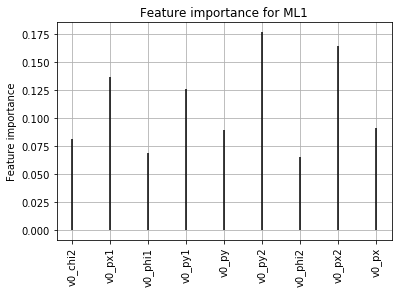

In [77]:
fig, ax = plt.subplots()
ax.vlines(range(len(ML1)),0,cla1.feature_importances_)
ax.set_xticks(range(len(ML1)))
ax.set_xticklabels(ML1,rotation='vertical')
ax.set_ylabel('Feature importance')
ax.set_title('Feature importance for ML1')
plt.grid()
# fig.savefig('figures/ML1_data_lambda_FI.pdf')

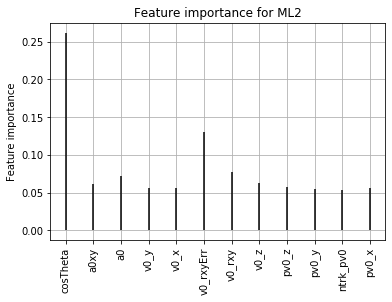

In [78]:
fig, ax = plt.subplots()
ax.vlines(range(len(ML2)),0,cla2.feature_importances_)
ax.set_xticks(range(len(ML2)))
ax.set_xticklabels(ML2,rotation='vertical')
# ax.set_xlabel('ML2 Features')
ax.set_ylabel('Feature importance')
ax.set_title('Feature importance for ML2')
plt.grid()
# fig.savefig('figures/ML2_data_lambda_FI.pdf')

Cross validation, create pseudolabels for test data with 1 ML and draw roc curve with the other:

Firstly investigate amount of signal and background in test data

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 23149 +/- 293, background: 456362


Text(0.5, 1.0, 'signal: 23149$\\pm$293, background: 456361')

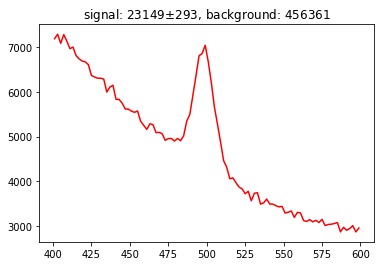

In [13]:
fig, ax = plt.subplots()
N_sig,N_bkgr,e_sig, M = hm.double_gauss_fit(test_data.v0_ks_mass,ax=ax,bins=100)
ax.set_title(f'signal: {N_sig:.0f}$\pm${e_sig:.0f}, background: {N_bkgr:.0f}')


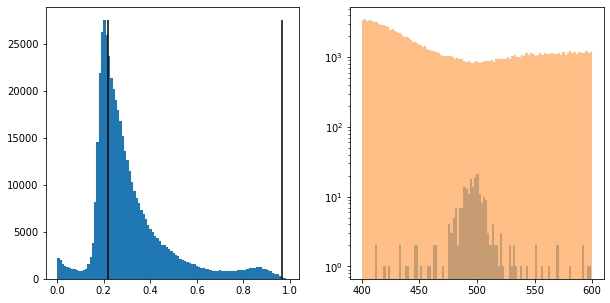

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

def test_labels(cla,features,sig_q=0.1,bkgr_q=0.3,bins=100):
    p = cla.predict_proba(test_data[features])[:,1]
    quantiles = np.quantile(p,(bkgr_q,1-sig_q))
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    vals, _, _ = ax[0].hist(p,bins=bins)
    ax[0].vlines(quantiles,0,max(vals))
    
    ax[1].hist(test_data.v0_ks_mass[p>=quantiles[1]],bins=bins,alpha=0.5)
    ax[1].hist(test_data.v0_ks_mass[p<=quantiles[0]],bins=bins,alpha=0.5)
    ax[1].set_yscale('log')

    mask_sig = (p>=quantiles[1])
    mask_bkgr = (p<=quantiles[0])
    labels = np.zeros(len(p))*np.nan
    labels[mask_sig] = 1
    labels[mask_bkgr] = 0
    
    return mask_sig + mask_bkgr, labels
    
mask1, label1 = test_labels(cla1,ML1,sig_q=0.0005,bkgr_q=0.3)

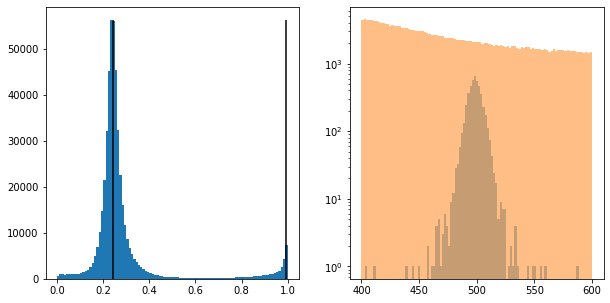

In [15]:
mask2, label2 = test_labels(cla2,ML2,sig_q=0.01,bkgr_q=0.5)

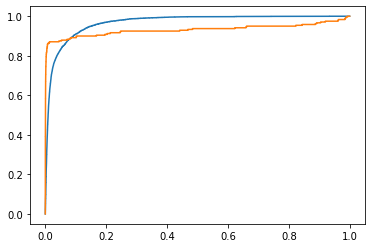

In [16]:
fig, ax = plt.subplots()

fpr1, tpr1, threshold1 = roc_curve(label2[mask2], 1-p1[mask2])
ax.plot(fpr1,tpr1)

fpr2, tpr2, threshold2 = roc_curve(label1[mask1], 1-p2[mask1])
ax.plot(fpr2,tpr2)

Now consider training in MC and test in data:

Firstly investigate validity of reweight

In [71]:
N = 6e5

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_split_data = len(data)//3
# train_test_slice = int(len(data)*0.8)
# train_data = data[:train_test_slice]
# test_data = data[train_test_slice:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]

train_split_mc = len(mc)//3
# mc[:train_split_mc].trueKs.sum(),mc[train_split_mc:].trueKs.sum()

In [72]:
train_data = data[:train_split_data]
train_data_cla = data[train_split_data:2*train_split_data]
test_data = data[2*train_split_data:]

train_mc = mc[:train_split_mc]
train_mc_cla = mc[train_split_mc:2*train_split_mc]
test_mc = mc[2*train_split_mc:]

def remove_outliers(data,q1=0.05,q2=0.95):
    mask = np.ones(len(data),dtype=bool)
    for col in data.columns:
        mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
    return mask

In [73]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from hep_ml.reweight import GBReweighter

# scaler_mc = RobustScaler(quantile_range=(0,100))
# scaler_data = RobustScaler(quantile_range=(0,100))

scaler_mc = MinMaxScaler()
scaler_data = MinMaxScaler()

scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[ML1+ML2][remove_outliers(train_data[ML1+ML2])]),columns=ML1+ML2)
scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[ML1+ML2][remove_outliers(train_mc[ML1+ML2])]),columns=ML1+ML2)

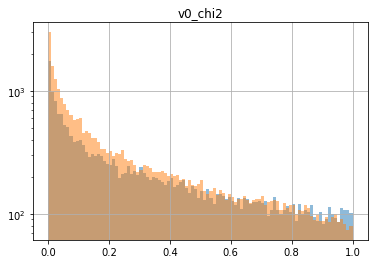

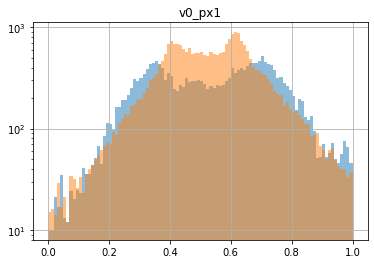

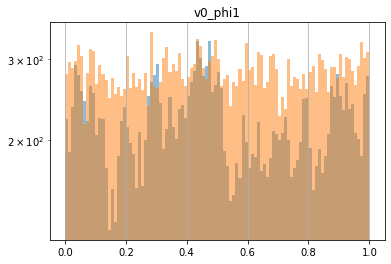

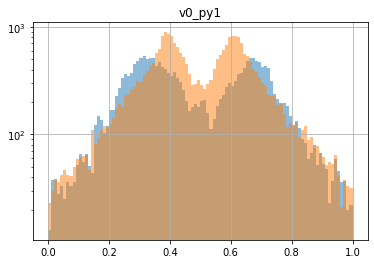

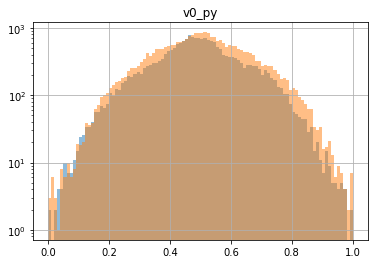

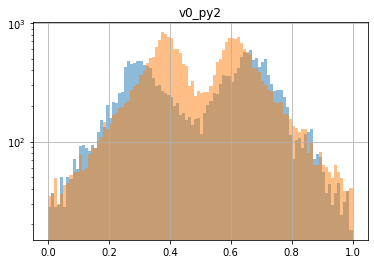

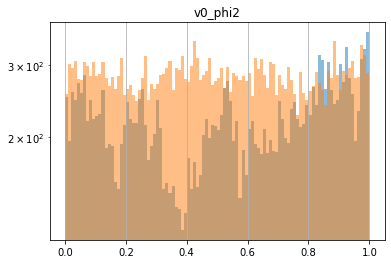

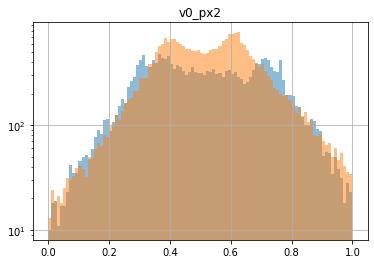

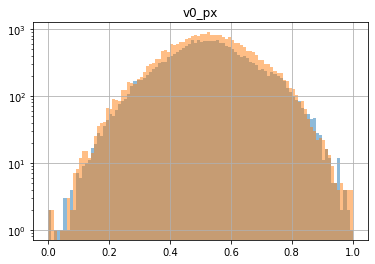

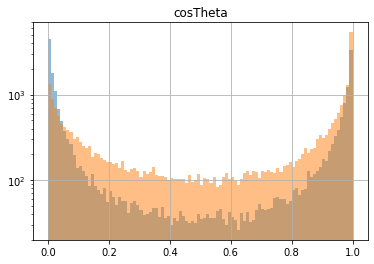

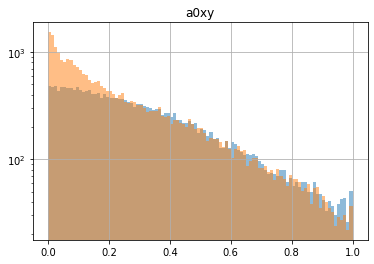

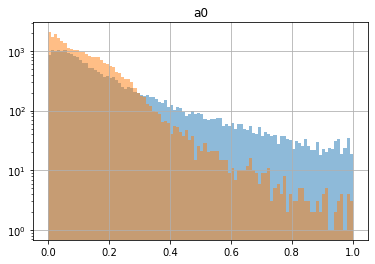

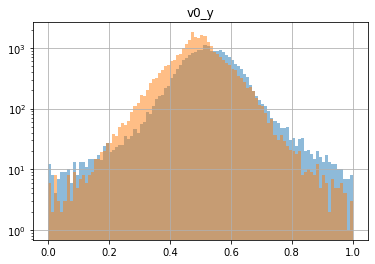

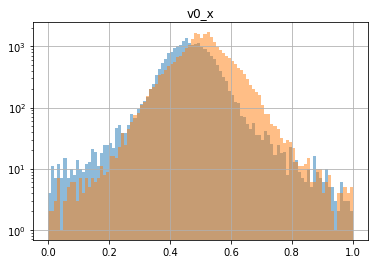

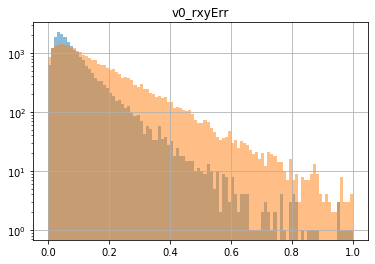

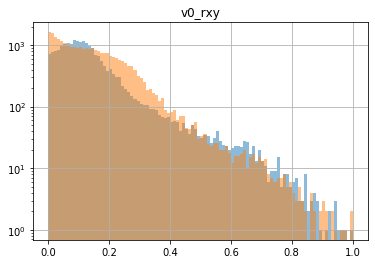

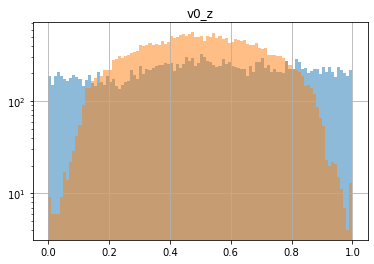

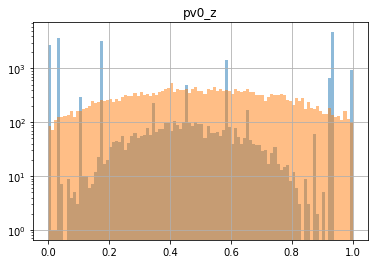

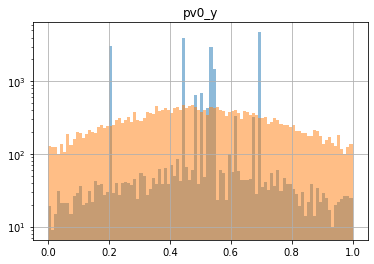

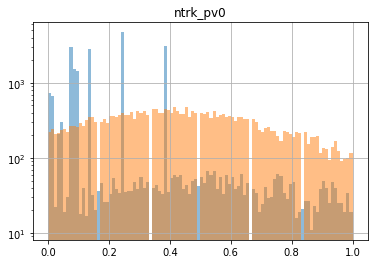

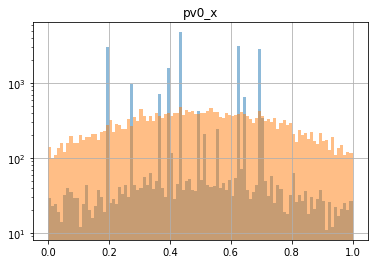

In [74]:
for feat in ML1+ML2:
    scaled_train_data[feat].hist(bins=100,alpha=0.5);
    scaled_train_mc[feat].hist(bins=100,alpha=0.5);
    plt.yscale('log')
    plt.title(feat)
    plt.show()

In [76]:
def scale_transform(scaler,data):
    return pd.DataFrame(scaler.transform(data),columns=data.columns)

scaled_train_data_cla = scale_transform(scaler_data,train_data_cla[ML1+ML2])
scaled_train_mc_cla = scale_transform(scaler_mc,train_mc_cla[ML1+ML2])

scaled_test_data = scale_transform(scaler_data,test_data[ML1+ML2])
scaled_test_mc = scale_transform(scaler_mc,test_mc[ML1+ML2])

In [77]:
cla = xgb.XGBClassifier()

cla.fit(X=pd.concat([scaled_train_data_cla,scaled_train_mc_cla]),
       y=np.append(np.zeros(len(scaled_train_data_cla)),np.ones(len(scaled_train_mc_cla))))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

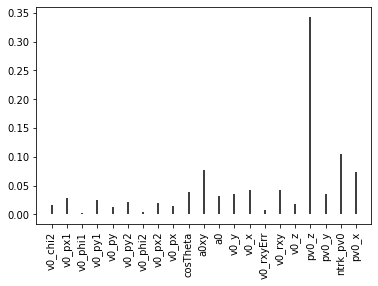

In [78]:
fig, ax = plt.subplots()
ax.vlines(range(len(ML1+ML2)),0,cla.feature_importances_)
ax.set_xticks(range(len(ML1+ML2)))
ax.set_xticklabels(ML1+ML2,rotation='vertical');

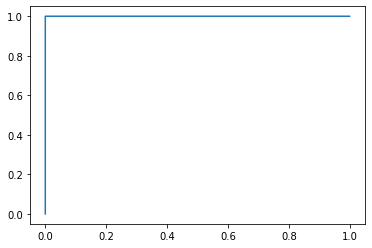

In [40]:
# fig, ax = plt.subplots()
# p = cla.predict_proba(pd.concat([scaled_train_data,scaled_train_mc]))[:,1]
# fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_train_data)),np.ones(len(scaled_train_mc))),p)

# ax.plot(fpr,tpr)

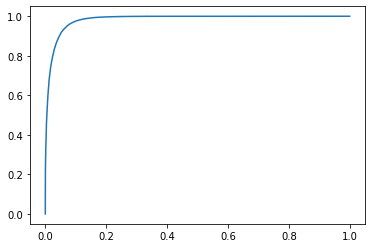

In [79]:
p = cla.predict_proba(pd.concat([scaled_test_data,scaled_test_mc]))[:,1]
fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_test_data)),np.ones(len(scaled_test_mc))),p)

fig, ax = plt.subplots()
ax.plot(fpr,tpr)

In [80]:
reweighter = GBReweighter()
reweighter.fit(original=scaled_train_mc, target=scaled_train_data)

GBReweighter(gb_args={}, learning_rate=0.2, loss_regularization=5.0,
             max_depth=3, min_samples_leaf=200, n_estimators=40)

In [95]:
mc_weights = reweighter.predict_weights(scaled_train_mc_cla)

In [111]:
cla_reweight = xgb.XGBClassifier()

mask = mc_weights < np.quantile(mc_weights,(0.9999))

cla_reweight.fit(X=pd.concat([scaled_train_data_cla,scaled_train_mc_cla[mask]]),
                 y=np.append(np.zeros(len(scaled_train_data_cla)),np.ones(len(scaled_train_mc_cla[mask]))),
                sample_weight = np.append(np.ones(len(scaled_train_data_cla)),mc_weights[mask]))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

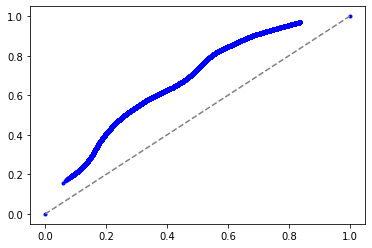

In [113]:
p_reweight = cla_reweight.predict_proba(pd.concat([scaled_test_data,scaled_test_mc]))[:,1]
fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_test_data)),np.ones(len(scaled_test_mc))),p_reweight)

fig, ax = plt.subplots()
ax.plot(fpr,tpr,'b.')
ax.plot([0,1],[0,1],c='grey',linestyle='--')

In [88]:
p_reweight

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)